Code von der Blog Seite: 
    http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import pandas as pd
import time
import datetime
%matplotlib inline

def dateparse (ts_str):    
    return datetime.datetime.strptime(ts_str, '%Y%m%d_%H:%M:%S')

df = pd.read_csv('data/LU_dat/VSP_86303/all_together.csv.gz', compression='gzip', index_col='timestamp', parse_dates=True, date_parser=dateparse)

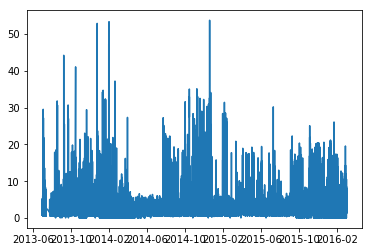

In [2]:
dataset = df[df['PQ_SVCT'] < 15000]['PQ_SVCT']
plt.plot(dataset)
plt.show()

In [88]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [89]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [90]:
# load the dataset
dataframe = dataset = df[df['PQ_SVCT'] < 15000]['PQ_SVCT']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [91]:
# cut dataframe
# 177056
dataset = dataset[:250003,]

In [92]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

/Users/mca/anaconda/envs/deeplearning/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/mca/anaconda/envs/deeplearning/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [93]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

175002 75001


In [94]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return numpy.array(dataX), numpy.array(dataY)

In [95]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
#train

In [96]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(175000, 1, 1)

In [99]:
# create and fit the LSTM network
#print(len(train))
batch_size = 100
model = Sequential()
#model.add(LSTM(16, input_shape=(1,look_back), return_sequences=True))
#model.add(LSTM(16, input_shape=(1,look_back)))
#model.add(LSTM(16, batch_input_shape=(10,1,look_back),stateful=True))
#model.add(LSTM(16, return_sequences=True))
model.add(LSTM(32,
               input_shape=(1, look_back),
               batch_size=batch_size,
               return_sequences=True,
               stateful=True))
model.add(LSTM(32,
               return_sequences=False,
               stateful=True))
#model.add(Dense(1))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (100, 1, 32)              4352      
_________________________________________________________________
lstm_44 (LSTM)               (100, 32)                 8320      
_________________________________________________________________
batch_normalization_16 (Batc (100, 32)                 128       
_________________________________________________________________
dropout_19 (Dropout)         (100, 32)                 0         
_________________________________________________________________
dense_26 (Dense)             (100, 1)                  33        
Total params: 12,833.0
Trainable params: 12,769.0
Non-trainable params: 64.0
_________________________________________________________________


In [100]:
model.fit(trainX, trainY, epochs=100, batch_size=batch_size, verbose=2)

Epoch 1/100
15s - loss: 5.0745e-04
Epoch 2/100
14s - loss: 4.4820e-04
Epoch 3/100


KeyboardInterrupt: 

In [45]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
invTrainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
invTestY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(invTrainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(invTestY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: Found array with dim 3. Estimator expected <= 2.

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


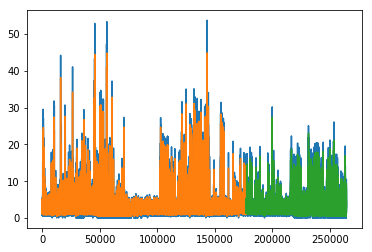

In [18]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = np.reshape(trainPredict, len(trainPredict))
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = np.reshape(testPredict, len(testPredict))
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


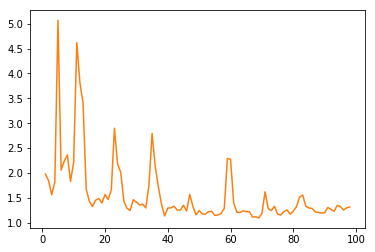

In [19]:
plt.plot(scaler.inverse_transform(dataset)[len(trainPredictPlot):len(trainPredictPlot)+100])
plt.plot(trainPredictPlot[1:100])

In [17]:
model.save('LA2.h5')